- `torch` is the main PyTorch library.
- `torch.nn` contains the neural network building blocks, such as layers, activation functions, loss functions, etc.
- `torch.optim` contains the optimization algorithms for training the model.
- `torchvision.datasets` contains the pre-built datasets, such as MNIST.
- `torchvision.transforms` contains the image transformations, such as normalization, resizing, etc.
- `seaborn` & `matplotlib.pyplot` are used to plot the training loss and test accuracy

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import seaborn as sns
import matplotlib.pyplot as plt

- `transforms.Compose` creates a pipeline of transformations to apply to each image in the dataset.
- `transforms.ToTensor()` converts the image to a PyTorch tensor, which is the format required by PyTorch models.
- `transforms.Normalize` normalizes the image with mean=0.5 and std=0.5, which helps with the convergence of the model.
- `datasets.MNIST` loads the MNIST dataset and applies the specified transformations to each image.
- `torch.utils.data.DataLoader` creates a data loader object to load the dataset in batches during training and testing.

In [94]:
# define transformation to apply to each image in the dataset
transform = transforms.Compose([
    transforms.ToTensor(), # convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the image with mean=0.5 and std=0.5
])

# load the MNIST training and testing datasets
train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

# create data loaders to load the datasets in batches during training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


- `transforms.Compose` creates a pipeline of transformations to apply to each image in the dataset.
- `transforms.ToTensor()` converts the image to a PyTorch tensor, which is the format required by PyTorch models.
- `transforms.Normalize` normalizes the image with mean=0.5 and std=0.5, which helps with the convergence of the model.
- `datasets.MNIST` loads the MNIST dataset and applies the specified transformations to each image.
- `torch.utils.data.DataLoader` creates a data loader object to load the dataset in batches during training and testing.

In [95]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hid1, dim_hid2, dim_out):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, dim_hid1) # input layer (784) -> hidden layer (128)
        self.fc2 = nn.Linear(dim_hid1, dim_hid2) # hidden layer (128) -> hidden layer (64)
        self.fc3 = nn.Linear(dim_hid2, dim_out) # hidden layer (64) -> output layer (10)
        self.relu = nn.ReLU() # activation function

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input image
        x = self.relu(self.fc1(x)) # apply the first hidden layer and activation function
        x = self.relu(self.fc2(x)) # apply the second hidden layer and activation function
        x = self.fc3(x) # apply the output layer
        return x


In [96]:
class MLP2(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size)]) # input layer
        self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(1, num_layers-1)]) # Hidden Layers
        self.linears.append(nn.Linear(layers_size, output_size))
        self.relu = nn.ReLU() # activation function

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input image
        for layer in self.linears:
            x = self.relu(layer(x))
        return x


## MLP for FL

This model has a flexible number of layers


In [97]:
class MLP3(nn.Module):
    def __init__(self, layers_shape):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers_shape[i], layers_shape[i+1]) for i in range(len(layers_shape) - 1)]) # Define layers list
        self.relu = nn.ReLU() # activation function
        self.soft = nn.Softmax() # output function

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input image
        for layer in self.linears[:-1]:
            x = self.relu(layer(x))
        x = self.soft(self.linears[-1](x))
        return x

- `nn.Module` is the base class for all neural network modules in PyTorch.
- `super().__init__()` initializes the base class.
- `nn.Linear` creates a linear layer with the specified input and output sizes.
- `nn.ReLU` creates a rectified linear activation function.
- `forward` defines the forward pass of the model, i.e., how the input is transformed into the output.

In [98]:
# Model parameters
parameters = [ 28 * 28, # input
                512, 256, 128, 64,
                10 ] #output
# instantiate the model
# model = MLP(din, dhid1, dhid2, dout)
# model = MLP2(din, 5, 100, 10)
print(parameters)
model = MLP3(parameters)
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # performs stochastic gradient descent with adaptive learning rate


SyntaxError: invalid syntax. Perhaps you forgot a comma? (578392750.py, line 3)

In [ ]:
# set the device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# set the number of epochs to train the model
n_epochs = 10

# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0

    # train the model
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # reset the gradients to zero
        output = model(images) # forward pass
        loss = criterion(output, labels) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        train_loss += loss.item() * images.size(0) # accumulate the training loss
        _, pred = torch.max(output, 1) # get the predicted labels
        train_acc += (torch.sum(pred == labels.data)).item() # compute the training accuracy

    # test the model
    model.eval()
    with torch.no_grad(): # disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images) # forward pass
            loss = criterion(output, labels) # compute the loss
            test_loss += loss.item() * images.size(0) # accumulate the testing loss
            _, pred = torch.max(output, 1) # get the predicted labels
            test_acc += torch.sum(pred == labels.data).item() # compute the testing accuracy

    # compute the average losses and accuracies for the epoch
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)

    # append the losses and accuracies to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # print the progress
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


/tmp/ipykernel_13374/732697659.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.soft(self.linears[-1](x))


Epoch 1/10, Train Loss: 1.7783, Test Loss: 1.6169, Train Acc: 0.7052, Test Acc: 0.8619
Epoch 2/10, Train Loss: 1.5889, Test Loss: 1.5723, Train Acc: 0.8829, Test Acc: 0.8950
Epoch 3/10, Train Loss: 1.5665, Test Loss: 1.5549, Train Acc: 0.9002, Test Acc: 0.9125
Epoch 4/10, Train Loss: 1.5556, Test Loss: 1.5476, Train Acc: 0.9104, Test Acc: 0.9166
Epoch 5/10, Train Loss: 1.5491, Test Loss: 1.5476, Train Acc: 0.9155, Test Acc: 0.9172
Epoch 6/10, Train Loss: 1.5452, Test Loss: 1.5417, Train Acc: 0.9193, Test Acc: 0.9224
Epoch 7/10, Train Loss: 1.5415, Test Loss: 1.5454, Train Acc: 0.9228, Test Acc: 0.9184
Epoch 8/10, Train Loss: 1.5393, Test Loss: 1.5378, Train Acc: 0.9245, Test Acc: 0.9255
Epoch 9/10, Train Loss: 1.5377, Test Loss: 1.5333, Train Acc: 0.9257, Test Acc: 0.9291
Epoch 10/10, Train Loss: 1.5348, Test Loss: 1.5373, Train Acc: 0.9283, Test Acc: 0.9256


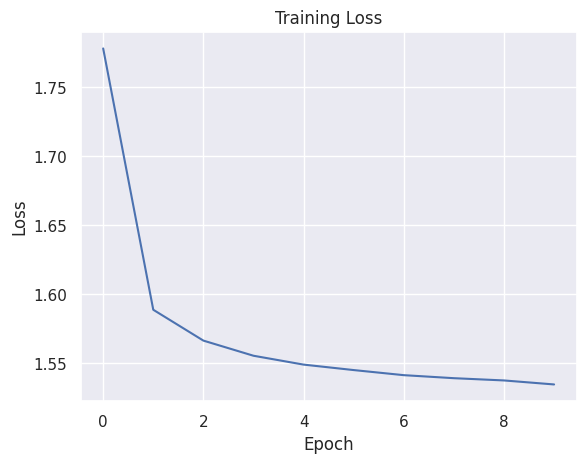

In [ ]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


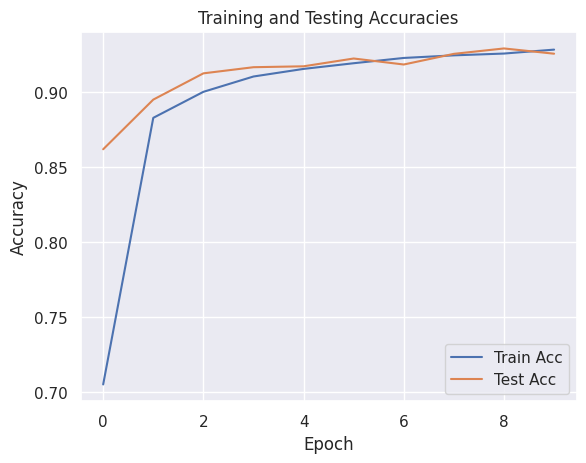

In [ ]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Federated Learning Methods